# Analyzing multi-temperature simulations with PyEMMA

### Example: the 1D asymmetric double well potential

In multi-temperature simulations, the bias energies usually are computed via the heat bath temperature difference from a reference and the potential energies of the simulated frames:

$$b^{(i)}(\mathbf{x}) = \left( \frac{1}{\text{k}_\text{B} T^{(i)}} - \frac{1}{\text{k}_\text{B} T^{\circ}} \right) U(\mathbf{x}).$$

If the potential energies are stored in reduced form,

$$u^{(j)}(\mathbf{x}) = \frac{U(\mathbf{x})}{\text{k}_\text{B} T^{(j)}},$$

the bias is computed via

$$b^{(i)}(\mathbf{x}) = \left( \frac{1}{\text{k}_\text{B} T^{(i)}} - \frac{1}{\text{k}_\text{B} T^{\circ}} \right) \text{k}_\text{B} T^{(j)} u^{(j)}(\mathbf{x}).$$

In [1]:
# Imports and matplotlib customization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10

# Load precomputed simulation data
data = np.load('data/adw_mt.npz')
energy_trajs = [np.asarray(l, dtype=np.float64) for l in data['arr_0']]
temp_trajs = [np.asarray(l, dtype=np.float64) for l in data['arr_1']]
trajs = [np.asarray(l, dtype=np.float64).reshape((-1, 1)) for l in data['arr_2'].tolist()]
centers = data['arr_3']
reference = data['arr_4']

### Looking at the data

We have a total of 14 independent trajectories: seven for each kT=1.0 and seven for kT=5.0. The left plot shows the time evolution for the target temperature, the right panel shows the trajectories for the high temperature.

We can observe two issues: 1) the target temperature (unbiased) trajectories sample only the ranges $-1.5 \leq x \leq -1.0$ and $0.8 \leq x \leq 1.5$ well, and we have very few crossings between these ranges. 2) The high temperature trajectories sample the whole range well.

Please note that while we have used a constant kT value for each simulation, the proedure would be the same with temperature changes within the trajectories.

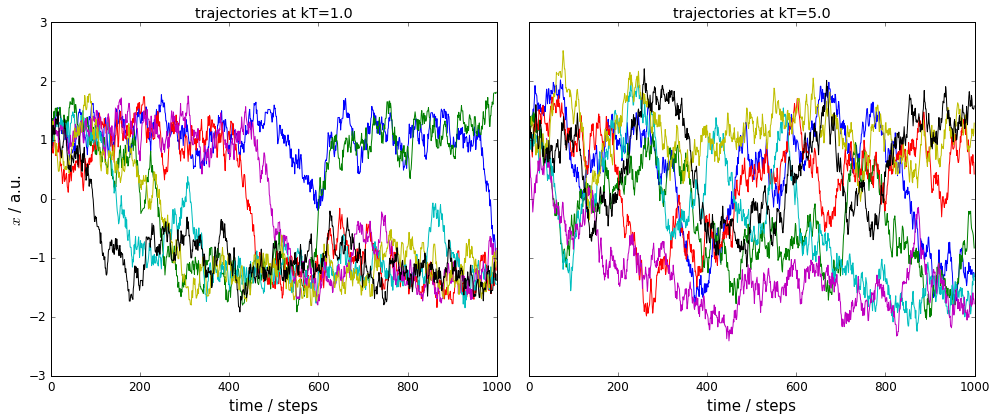

In [2]:
# Plot the biased and unbiased trajectories
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for t, traj in zip(temp_trajs, trajs):
    if np.all(t == 1.0):
        axes[0].plot(traj)
    else:
        axes[1].plot(traj)
axes[0].set_ylabel(r"$x$ / a.u.")
axes[0].set_title(r"trajectories at kT=1.0")
axes[1].set_title(r"trajectories at kT=5.0")
for ax in axes.flat:
    ax.set_xlabel(r"time / steps")
fig.tight_layout()

### Discretization

We start by discretizing the loaded time series using predefined cluster centers.

In [3]:
dtrajs = pyemma.coordinates.assign_to_centers(data=trajs, centers=centers) # discrete trajectories
dtrajs0 = [dtraj for t, dtraj in zip(temp_trajs, dtrajs) if np.all(t == 1.0)] # discrete trajectories for kT=1.0

### Implied timescales

To get a first guess which lag time to use, we make an implied timescale plot: one with only the unbiased data and the standard MSM approach and one with all data and TRAM.

For the MSM, we create an implied timescales (ITS) object which can be passed to a suitable plotting function.

In case of TRAM (or dTRAM), we have to use the regular estimation API function with a list of lag times. The list of estimated MEMMs is then passed to a suitable plotting function. Please note that this approach takes considerably more time, but we do not discard the intermediate results and can use the MEMMs at all lag times later on.

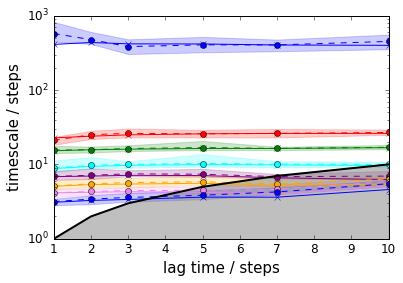

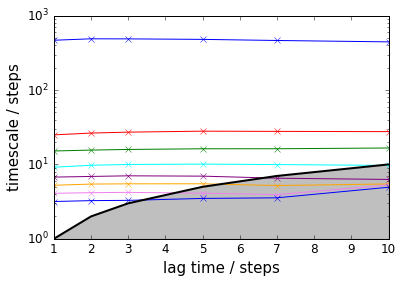

In [4]:
lags = [1, 2, 3, 5, 7, 10]

# MSM approach
its = pyemma.msm.its(dtrajs0, lags=lags, nits=8, errors='bayes')
pyemma.plots.plot_implied_timescales(its, marker='x')

# TRAM approach
tram = pyemma.thermo.estimate_multi_temperature(
    energy_trajs, temp_trajs, dtrajs,
    maxiter=25000, maxerr=1.0E-15, save_convergence_info=10,
    energy_unit='kT', temp_unit='kT', estimator='tram', lag=lags,
    init='mbar', init_maxiter=5000, init_maxerr=1.0E-12)
pyemma.plots.plot_memm_implied_timescales(tram, nits=8, annotate=False, marker='x')

The TRAM approach further allows to check implied timescales for all thermodynamic states, i.e., temperatures:

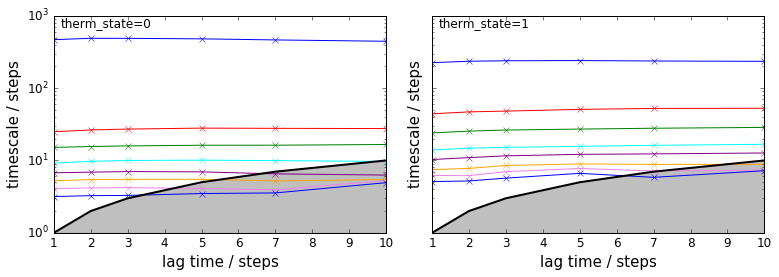

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_memm_implied_timescales(tram, nits=8, therm_state=i, ax=ax, marker='x')
fig.tight_layout()

### Performance

We compare the TRAM result with other methods, i.e., WHAM, dTRAM, and an MSM on the unbiased data with lag time $\tau=7$ steps. Please note that we do not need to rerun the TRAM estimation, we can directly access one of the TRAM objects in the above list.

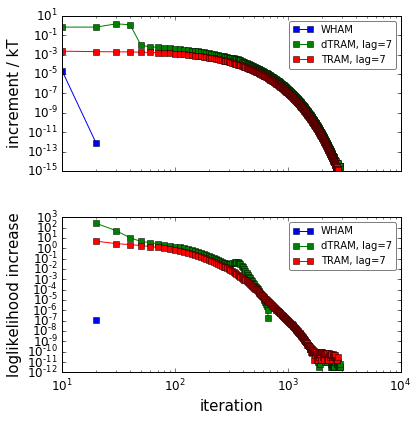

In [6]:
tram_obj = tram[4]

# Use WHAM
wham = pyemma.thermo.estimate_multi_temperature(
    energy_trajs, temp_trajs, dtrajs,
    maxiter=100000, maxerr=1.0E-15, save_convergence_info=10,
    energy_unit='kT', temp_unit='kT', estimator='wham')

# Use dTRAM
dtram = pyemma.thermo.estimate_multi_temperature(
    energy_trajs, temp_trajs, dtrajs,
    maxiter=10000, maxerr=1.0E-15, save_convergence_info=10,
    energy_unit='kT', temp_unit='kT', estimator='dtram', lag=7)

# Plot the convergence behaviour (only WHAM, dTRAM, TRAM)
pyemma.plots.plot_convergence_info([wham, dtram, tram_obj])

# Build an MSM of the unbiased data
msm = pyemma.msm.estimate_markov_model(dtrajs=dtrajs0, lag=7)

Below, we compare the estimated free energy profile (thermodynamics) for the different estimators. We observe
* the MSM fails at the barrier and the right metastable state
* WHAM fails for both metastable states
* dTRAM and TRAM are in good agreement with the reference

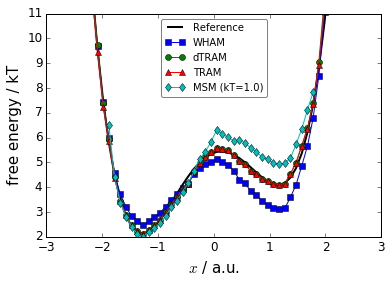

In [7]:
fig, ax = plt.subplots()
ax.plot(reference[0, :], reference[1, :], linewidth=2, color='black', label="Reference")
ax.plot(centers[wham.active_set, 0], wham.free_energies, '-s', label="WHAM")
ax.plot(centers[dtram.active_set, 0], dtram.free_energies, '-o', label="dTRAM")
ax.plot(centers[tram_obj.active_set, 0], tram_obj.free_energies, '-^', label="TRAM")
ax.plot(centers[msm.active_set, 0], -np.log(msm.stationary_distribution), '-d', label="MSM (kT=1.0)")
ax.set_xlabel(r"$x$ / a.u.")
ax.set_ylabel(r"free energy / kT")
ax.set_ylim([2, 11])
ax.legend(loc=9, fancybox=True, framealpha=0.5)

Now, we compare mean first passage times (MFPT, kinetics) for MSM, dTRAM, and TRAM; reference values are 270$\pm$30 steps and 2300$\pm$200 steps. We observe that dTRAM and TRAM are in good agreement with the reference for the slow process while the MSM visibly overestimates the MFPT; dTRAM/TRAM slightly overestimate the MFPT of the fast process.

  MSM MFPT[red->green] =    266 steps
  MSM MFPT[green->red] =   4458 steps
dTRAM MFPT[red->green] =    326 steps
dTRAM MFPT[green->red] =   2241 steps
 TRAM MFPT[red->green] =    326 steps
 TRAM MFPT[green->red] =   2245 steps


(1, 9)

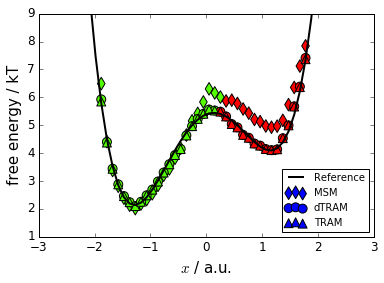

In [8]:
# Run PCCA to find metastable sets
msm.pcca(2)
dtram.msm.pcca(2)
tram_obj.msm.pcca(2)

# Print MFPTs
print("  MSM MFPT[red->green] = %6.0f steps" % msm.mfpt(msm.metastable_sets[0], msm.metastable_sets[1]))
print("  MSM MFPT[green->red] = %6.0f steps" % msm.mfpt(msm.metastable_sets[1], msm.metastable_sets[0]))
print("dTRAM MFPT[red->green] = %6.0f steps" % dtram.msm.mfpt(
        dtram.msm.metastable_sets[0], dtram.msm.metastable_sets[1]))
print("dTRAM MFPT[green->red] = %6.0f steps" % dtram.msm.mfpt(
        dtram.msm.metastable_sets[1], dtram.msm.metastable_sets[0]))
print(" TRAM MFPT[red->green] = %6.0f steps" % tram_obj.msm.mfpt(
        tram_obj.msm.metastable_sets[0], tram_obj.msm.metastable_sets[1]))
print(" TRAM MFPT[green->red] = %6.0f steps" % tram_obj.msm.mfpt(
        tram_obj.msm.metastable_sets[1], tram_obj.msm.metastable_sets[0]))

# Plot the free energy profile with color-coded metastable assignment
fig, ax = plt.subplots()
ax.plot(reference[0, :], reference[1, :], linewidth=2, color='black', label="Reference")
ax.scatter(
    centers[msm.active_set, 0], -np.log(msm.stationary_distribution),
    c=msm.metastable_assignments, cmap=mpl.cm.prism, s=80, label='MSM', marker='d')
ax.scatter(
    centers[dtram.active_set[dtram.msm_active_set], 0], dtram.f[dtram.msm_active_set],
    c=dtram.msm.metastable_assignments, cmap=mpl.cm.prism, s=80, label='dTRAM')
ax.scatter(
    centers[tram_obj.active_set[tram_obj.msm_active_set], 0], tram_obj.f[tram_obj.msm_active_set],
    c=tram_obj.msm.metastable_assignments, cmap=mpl.cm.prism, s=80, marker='^', label='TRAM')
ax.set_xlabel(r"$x$ / a.u.")
ax.set_ylabel(r"free energy / kT")
ax.legend(loc=4)
ax.set_ylim([1, 9])

### Conclusion

This notebook illustrates how we can use PyEMMA's thermo package to analyze multi-temperature simulations. We have learned how to

* invoke the ``pyemma.thermo.estimate_multi_temperature()`` API function,
* specify a certain estimator (WHAM, dTRAM, or TRAM)
* visualize implied timescales for arbitraty thermodynamic states
* visualize the convergence behaviour of an MEMM estimation
* access thermodynamic and kinetic information

We have also seen that transition-based reweighting of mixed biased and unbiased data outperforms traditional approaches.